In [29]:
# from google.colab import drive    #原来从谷歌云盘导入 现在从本地导入 进行注释
#drive.mount('/content/gdrive')   # 挂载Google Drive（云端数据存储）   #不挂载Google Drive

In [30]:
#测试tensorflow的GPU是否驱动
import tensorflow as tf
print("TensorFlow 版本:", tf.__version__)  # 应输出 2.x.x（如 2.12.0）
print("模块路径：", tf.__file__)   #输出tensorflow目前路径
print("Keras 版本:", tf.keras.__version__)    
print("GPU 可用:", tf.test.is_gpu_available()) # 检查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')  
print("Num GPUs Available: ", len(gpus))    #可用GPU的数量
print("CUDA Built:", tf.test.is_built_with_cuda())     #是否用CUDA成功驱动
print("GPUs:", tf.config.list_physical_devices('GPU'))     #列出GPU名

TensorFlow 版本: 2.11.0
模块路径： c:\users\10978\appdata\local\programs\python\python37\lib\site-packages\tensorflow\__init__.py
Keras 版本: 2.11.0
GPU 可用: False
Num GPUs Available:  0
CUDA Built: False
GPUs: []


In [31]:
import sklearn
print(sklearn.__version__)  # 应输出版本号（如 1.2.2）

1.0.2


In [32]:
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Activation 
from tensorflow.keras.layers import Reshape, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D   #引入两个池化模块 改进模型
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print("引入库成功")
import scipy.io as sio

引入库成功


In [33]:
tf.test.gpu_device_name()  #没有GPU驱动 用CPU跑

''

In [34]:
#from google.colab import files  #本地读入文件 改成注释
#uploaded = files.upload()    #本地读入文件 改成注释

# from google.colab import drive

# drive.mount('/content')

In [35]:
#读取CSV文件
#原有从云端读入文件 以本地CSV文件形式读入
#import io   #本地读入文件 改成注释
#X = pd.read_csv(io.BytesIO(uploaded['RSS_total.csv']))    # 输入：16个AP的RSS信号（N×16矩阵）  本地读入原有代码做修改
#Y = pd.read_csv(io.BytesIO(uploaded['Label.csv']))        # 输出：标签为位置(x,y,z)和方向(α,β,γ)（N×6矩阵）  本地读入原有代码做修改
#import pandas as pd
#从本地直接读入文件
#X = pd.read_csv('RSS_total.csv', header=None)   # 输入特征（16列）
#Y = pd.read_csv('Label.csv', header=None)       # 输出标签（6列）
# 验证数据加载
#print("输入数据维度 (样本数, 特征数):", X.shape)
#print("标签数据维度 (样本数, 标签数):", Y.shape)

输入数据维度 (样本数, 特征数): (1000000, 16)
标签数据维度 (样本数, 标签数): (1000000, 6)


In [ ]:
#读取mat文件
#原有从云端读入文件 以本地mat文件形式读入
import scipy.io
# 加载 .mat 文件
data_X = scipy.io.loadmat('RSS_total.mat')  # 输入特征
data_Y = scipy.io.loadmat('Label.mat')      # 输出标签

# 使用正确的变量名进行读取
X = data_X['RSS_total']
Y = data_Y['Label']

# 打印维度确认
print("输入数据维度 (样本数, 特征数):", X.shape)
print("标签数据维度 (样本数, 标签数):", Y.shape)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)  #对训练集和测试集划分

In [37]:
print("- Training-set:\t\t{}".format(x_train.shape[0]))    
print("- Test-set:\t\t{}".format(x_test.shape[0]))
print(" Shape of train target set:{}".format(y_train.shape))
print(" Shape of test target set:{}".format(y_test.shape))

- Training-set:		900000
- Test-set:		100000
 Shape of train target set:(900000, 6)
 Shape of test target set:(100000, 6)


In [38]:
#输入标准化 标签标准化   将数据按特征（列）转换为均值为0、标准差为1的分布。 神经网络对输入数据的尺度敏感。1. 若特征量纲差异大（如一个特征范围是-100到100，另一个是0到1，梯度下降过程会不稳定，导致模型收敛困难。 2.加速收敛：标准化后的数据分布更均匀，优化器（如Adam）能更快找到最优解。 3.避免数值溢出：防止某些激活函数（如Sigmoid）在极端输入下饱和。
# 输入标准化（X）
scalerX = StandardScaler().fit(x_train)       # 基于训练集计算均值和标准差
x_train = scalerX.transform(x_train)          # 应用标准化到训练集
x_test = scalerX.transform(x_test)            # 使用相同的参数标准化测试集
scalerY = StandardScaler().fit(y_train)       # 对标签也进行标准化
y_train = scalerY.transform(y_train)

In [39]:
dim_in = x_train.shape[1]   # 输入特征维度（16）
dim_out = y_train.shape[1]     # 输出维度（6）
state_bias = True           #打开偏置
kernel_size = 16          # 卷积核大小       卷积窗口覆盖全部16个AP的RSS信号（可能意图捕捉全局依赖）。
filters = 64              # 卷积核数量  每层卷积输出64个特征图，增强特征提取能力。
p_dropout = 0.2           # Dropout率
activation_1 = 'relu'      # 卷积层激活函数
activation_2 = 'linear'      # 输出层激活函数 线性

In [61]:
##### [改进模块1：模型架构] #####

#CNN模型构建
#根据DeepSeek优化目标 ： 模型架构简化+池化   减少卷积层数，添加池化层提升特征抽象能力    待改进后的结构为：1. 第一层 （小卷积核+池化）   2. 第二卷（扩大感受野）  3.全连接层

model = Sequential()    #创建一个空的线性堆叠神经网络模型，在这个模型上你可以通过 add() 方法逐层构建你的网络。

model.add(InputLayer(input_shape=((dim_in))))         # 输入层（16维） 
model.add(Reshape((dim_in, 1)))                       # 转换为序列格式（16,1） 用于后续层的输入

#修改思路：每两层卷积后加池化

#第一层卷积块 
model.add(Conv1D(kernel_size=kernel_size, filters=filters, strides=1, padding='same', dilation_rate=1, activation=activation_1, use_bias=state_bias, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
model.add(Dropout(p_dropout))    # 随机丢弃20%神经元 设为0.2 
model.add(BatchNormalization())    # 批归一化

#第二层卷积块
model.add(Conv1D(kernel_size=kernel_size, filters=filters, strides=1, padding='same', dilation_rate=1, activation=activation_1, use_bias=state_bias, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))

#-------------------------------------------------------------
# 修改点1：二层后加入第一个池化层 
#model.add(MaxPooling1D(pool_size=2))   # 新增池化层（输出长度从16→8）
#-------------------------------------------------------------

model.add(Dropout(p_dropout))
model.add(BatchNormalization())

#第三层卷积块
model.add(Conv1D(kernel_size=kernel_size, filters=filters, strides=1, padding='same', dilation_rate=1, activation=activation_1, use_bias=state_bias, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
model.add(Dropout(p_dropout))
model.add(BatchNormalization())

#第四层卷积块
model.add(Conv1D(kernel_size=kernel_size, filters=filters, strides=1, padding='same', dilation_rate=1, activation=activation_1, use_bias=state_bias, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))

#-------------------------------------------------------------
#修改点2：四层后加入第二个池化层 
#model.add(MaxPooling1D(pool_size=2))   # 新增池化层（输出长度从8→4）
#-------------------------------------------------------------

model.add(Dropout(p_dropout))
model.add(BatchNormalization())

model.add(Flatten())      # 展平多维特征     # 展平为 (batch_size, 16*64)=1024 维向量
model.add(Dense(dim_out, use_bias=state_bias, activation=activation_2))     # 输出层   展平后接全连接层输出6个回归值。

In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 16, 1)             0         
                                                                 
 conv1d_16 (Conv1D)          (None, 16, 64)            1088      
                                                                 
 dropout_16 (Dropout)        (None, 16, 64)            0         
                                                                 
 batch_normalization_16 (Bat  (None, 16, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_17 (Conv1D)          (None, 16, 64)            65600     
                                                                 
 dropout_17 (Dropout)        (None, 16, 64)            0         
                                                      

In [63]:
# 模型编译与训练
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)   #Adam优化器参数
model.compile(optimizer=optimizer, loss='mse',  metrics=['mae'])     #损失函数：均方误差（Mean Squared Error）      # 评估指标：平均绝对误差（MAE）和MSE

In [64]:
%%time
#必须位于单元格第一行 前面不能有任何注释
#模型训练 完整遍历训练集30次   每次梯度更新使用batch_size=128个样本         validation_split=0.2 从训练集划出20%作为验证集（不参与训练），监控过拟合。

history = model.fit(x=x_train, y=y_train, epochs=30, batch_size=128, validation_split=0.2,verbose=1)

hist = pd.DataFrame(history.history)    # 转换为DataFrame
hist['epoch'] = history.epoch     # 添加epoch列
#hist   #展示
display(hist)  # 使用 display() 替代直接写 hist 以增强可视化
hist.to_csv('hist_total_.csv', index=False)     # 保存为CSV文件
#按照Deepseek建议合并单元格  确保变量作用域连续

Epoch 1/30
5625/5625 [==============================] - 200s 35ms/step - loss: 0.4617 - mae: 0.4185 - val_loss: 0.3512 - val_mae: 0.3167
Epoch 2/30
5625/5625 [==============================] - 195s 35ms/step - loss: 0.3713 - mae: 0.3527 - val_loss: 0.3245 - val_mae: 0.2988
Epoch 3/30
5625/5625 [==============================] - 195s 35ms/step - loss: 0.3551 - mae: 0.3405 - val_loss: 0.3145 - val_mae: 0.2901
Epoch 4/30
5625/5625 [==============================] - 201s 36ms/step - loss: 0.3471 - mae: 0.3349 - val_loss: 0.3065 - val_mae: 0.2803
Epoch 5/30
5625/5625 [==============================] - 195s 35ms/step - loss: 0.3415 - mae: 0.3311 - val_loss: 0.3037 - val_mae: 0.2782
Epoch 6/30
5625/5625 [==============================] - 203s 36ms/step - loss: 0.3377 - mae: 0.3286 - val_loss: 0.2964 - val_mae: 0.2752
Epoch 7/30
5625/5625 [==============================] - 199s 35ms/step - loss: 0.3350 - mae: 0.3267 - val_loss: 0.2997 - val_mae: 0.2756
Epoch 8/30
5625/5625 [===================

,loss,mae,val_loss,val_mae,epoch
0,0.461729,0.418507,0.351219,0.316656,0
1,0.371298,0.352724,0.324456,0.298801,1
2,0.355068,0.340493,0.314537,0.290112,2
3,0.347139,0.334905,0.306483,0.280261,3
4,0.341484,0.331112,0.303729,0.278201,4
5,0.337718,0.328643,0.296363,0.275234,5
6,0.335020,0.326693,0.299732,0.275583,6
7,0.332353,0.324920,0.283648,0.263197,7
8,0.330683,0.323736,0.287011,0.266407,8
9,0.328755,0.322481,0.284857,0.263049,9


Wall time: 1h 39min 13s


In [65]:
#按照Deepseek建议合并单元格  确保变量作用域连续

In [66]:
import matplotlib
print("当前版本:", matplotlib.__version__)  # 正确输出（例如 3.8.2）

当前版本: 3.5.3


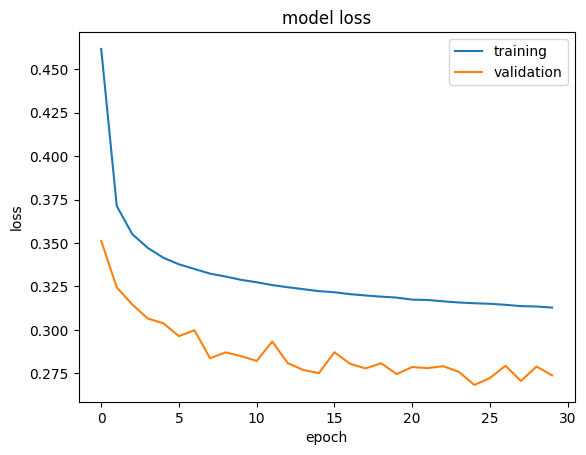

UsageError: unrecognized arguments: # Jupyter内嵌显示图表


In [67]:
# 损失曲线可视化
import matplotlib.pyplot as plt    
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.legend(['training','validation'])
plt.xlabel('epoch')
plt.show()
%matplotlib inline        # Jupyter内嵌显示图表

In [68]:
%%time
y_predict = model.predict(x_test)     # 预测测试集（标准化输入）

3125/3125 [==============================] - 11s 4ms/step
Wall time: 12 s


In [69]:
y_predict = scalerY.inverse_transform(y_predict)  # 反标准化（还原物理量纲）需将其转换回原始物理单位（如米、弧度），才能与实际标签（y_test）进行有意义比较。

In [70]:
y_test = pd.DataFrame(y_test)            # 转换真实标签为DataFrame
y_test.to_csv('y_test_total.csv', index=False)     # 存储测试集的真实标签值（即真实的位置和方向数据）
y_predict = pd.DataFrame(y_predict)             # 转换预测结果为DataFrame
y_predict.to_csv('y_predict_total.csv', index=False)      # 存储模型对测试集的预测结果（即模型预测的位置和方向数据）

In [71]:
#添加结果计算部分 MAE和 RMSE

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
# ============================================
# 1. 加载数据（假设文件在当前路径）
# ============================================
# 读取真实值和预测值（若文件有表头则移除 header=None）
columns = ['x', 'y', 'z', 'alpha', 'beta', 'gamma']    # 定义列名（与数据顺序严格对应）
y_result_true = pd.read_csv('y_test_total.csv', names=columns)
y_result_pred = pd.read_csv('y_predict_total.csv', names=columns)
#对读取数据进行校验    检查是否有缺失值
#print("真实标签缺失值统计:\n", y_result_true.isnull().sum())
#print("\n预测值缺失值统计:\n", y_result_pred.isnull().sum())

# 2. 分维度计算 MAE 和 RMSE
# ============================================
metrics = {}     # 初始化存储结果的字典
for col in columns:
    # 单维度误差计算
   
    true_col = y_result_true[col]   # 提取当前维度的真实值
    pred_col = y_result_pred[col]   # 提取当前维度的预测值


    # 计算平均绝对误差 (MAE)
    mae = mean_absolute_error(true_col, pred_col)

    # 计算均方根误差 (RMSE)
    rmse = np.sqrt(mean_squared_error(true_col, pred_col))

    # 存储结果在metrics中
    metrics[col] = {'MAE': mae, 'RMSE': rmse}


# ============================================
# 3. 计算三维空间位置误差  
# ============================================
# 提取位置坐标（前三列：x, y, z）
pos_true = y_result_true[['x', 'y', 'z']].values  # 转换为NumPy数组
pos_pred = y_result_pred[['x', 'y', 'z']].values

# 计算每个样本的三维欧氏距离误差  # 公式：sqrt( (x_true - x_pred)^2 + (y_true - y_pred)^2 + (z_true - z_pred)^2 )
position_errors = np.sqrt(np.sum((pos_true - pos_pred)**2, axis=1))

# 计算整体指标
mae_3d = np.mean(position_errors)        # 总的三维误差的MAE
rmse_3d = np.sqrt(np.mean(position_errors**2))  # 总的三维误差的RMSE


# 计算整体 MAE 和 RMSE
mae_3d = np.mean(position_errors)
rmse_3d = np.sqrt(np.mean(position_errors**2))

# ============================================
# 4. 结果输出
# ============================================
# 打印分维度结果表头
print("\n" + "="*50)
print("{:<8} | {:<10} | {:<10}".format("维度", "MAE", "RMSE"))
print("-"*50)

# 逐行打印每个维度的指标
for col in columns:
    print("{:<8} | {:<10.4f} | {:<10.4f}".format(
        col,
        metrics[col]['MAE'],
        metrics[col]['RMSE']
    ))

# 打印三维位置误差结果
print("="*50)
print("三维空间位置误差:")
print(f"- MAE: {mae_3d:.4f}")
print(f"- RMSE: {rmse_3d:.4f}")
print("="*50)



维度       | MAE        | RMSE      
--------------------------------------------------
x        | 0.0636     | 0.0907    
y        | 0.0716     | 0.1012    
z        | 0.0475     | 0.0649    
alpha    | 0.1913     | 0.5276    
beta     | 0.0219     | 0.0301    
gamma    | 0.0271     | 0.0384    
三维空间位置误差:
- MAE: 0.1229
- RMSE: 0.1506


In [72]:
#以下部分是一个独立的K近邻回归模型，与CNN无关   目的：作为基线模型（Baseline），用于对比CNN模型的性能（例如比较两者的MAE/MSE）。


In [73]:
#from sklearn.neighbors import KNeighborsRegressor
#neigh = KNeighborsRegressor(n_neighbors=4)

In [74]:
%%time
#neigh.fit(x_train, y_train)

Wall time: 0 ns


In [58]:
%%time
#y_predict = neigh.predict(x_test)

Wall time: 0 ns


In [1]:
import numpy as np
print(np.__version__)

1.21.6
